In [1]:
import proplot
import numpy as np
import xarray as xr

import plotting

In [2]:
plotting.configure_style()

In [3]:
SIMULATED_DIURNAL_CYCLE_DATA = "simulated_diurnal_cycles.zarr"
OBSERVED_DIURNAL_CYCLE_DATA = "IMERG-diurnal-cycle.nc"


def open_diurnal_cycle_data():
    simulated = xr.open_zarr(SIMULATED_DIURNAL_CYCLE_DATA)
    simulated = simulated.sel(configuration=["Baseline", "Nudged", "Fine resolution (year two)"])
    simulated = simulated.sel(region="land |lat| <= 60")
    simulated = simulated.sel(climate="Unperturbed")
    
    observed = xr.open_dataset(OBSERVED_DIURNAL_CYCLE_DATA)
    observed = observed.sel(region="land |lat| <= 60")
    observed = observed.assign_coords(configuration="IMERG").expand_dims("configuration")

    merged = xr.concat([simulated, observed], dim="configuration")
    return (merged - merged.mean("local_time_bin")).precipitation


def open_error_data(variables, validation_year):
    bias = xr.open_dataset("annual_mean_bias.nc")[variables].sel(validation_year=validation_year)
    metrics = xr.open_dataset("annual_mean_metrics.nc")[variables].sel(validation_year=validation_year)
    return bias, metrics

In [4]:
VARIABLES = ["total_precipitation_rate", "surface_temperature"]
VALIDATION_YEAR = "Year two"

diurnal_cycles = open_diurnal_cycle_data()
bias, metrics = open_error_data(VARIABLES, VALIDATION_YEAR)
bias = bias.sel(climate="Unperturbed").mean("time")
metrics = metrics.sel(climate="Unperturbed", region="land").mean("time")

In [5]:
COLORS = [
    "#000000",
    "#E69F00",
    "#56B4E9",
]

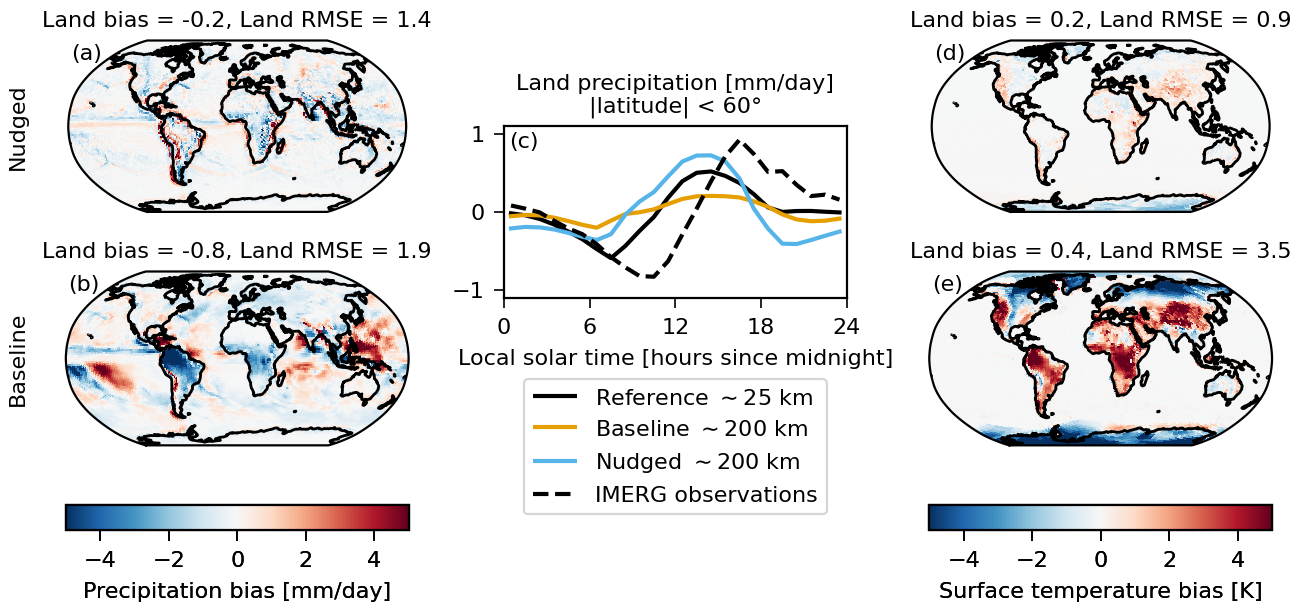

In [6]:
array = [
    [1, 0, 3],
    [1, 2, 3],
    [4, 2, 6],
    [4, 0, 6]
]

fig, axes = proplot.subplots(
    array,
    figwidth=6.5,
    refaspect=2.0,
    proj={1: "robin", 2: None, 3: "robin", 4: "robin", 5: "robin"},
    sharex=False
)
ax1, ax2, ax3, ax4, ax6 = axes

p1 = plotting.plot_map(ax1, bias.sel(configuration="Nudged"), "total_precipitation_rate", -5, 5, discrete=False)
p1 = plotting.plot_map(ax4, bias.sel(configuration="Baseline"), "total_precipitation_rate", -5, 5, discrete=False)

diurnal_cycles.sel(configuration="Fine resolution (year two)").plot(ax=ax2, color=COLORS[0], ls="-", label="Reference $\sim$25 km")
diurnal_cycles.sel(configuration="Baseline").plot(ax=ax2, color=COLORS[1], ls="-", label="Baseline $\sim$200 km")
diurnal_cycles.sel(configuration="Nudged").plot(ax=ax2, color=COLORS[2], ls="-", label="Nudged $\sim$200 km")
diurnal_cycles.sel(configuration="IMERG").plot(ax=ax2, color=COLORS[0], ls="--", label="IMERG observations")

ax2.set_xticks(np.arange(0, 25, 6))
ax2.set_xlabel("Local solar time [hours since midnight]")
ax2.set_ylabel("")
ax2.set_ylim([-1.1, 1.1])
ax2.set_title("")
ax2.legend(loc="bottom", ncol=1)

p2 = plotting.plot_map(ax3, bias.sel(configuration="Nudged"), "surface_temperature", -5, 5, discrete=False)
p2 = plotting.plot_map(ax6, bias.sel(configuration="Baseline"), "surface_temperature", -5, 5, discrete=False)

nudged_land_bias = metrics.sel(configuration="Nudged").total_precipitation_rate.sel(metric="mean").item()
nudged_land_rmse = metrics.sel(configuration="Nudged").total_precipitation_rate.sel(metric="rmse").item()
baseline_land_bias = metrics.sel(configuration="Baseline").total_precipitation_rate.sel(metric="mean").item()
baseline_land_rmse = metrics.sel(configuration="Baseline").total_precipitation_rate.sel(metric="rmse").item()

ax1.set_title(f"Land bias = {nudged_land_bias:0.1f}, Land RMSE = {nudged_land_rmse:0.1f}")
ax4.set_title(f"Land bias = {baseline_land_bias:0.1f}, Land RMSE = {baseline_land_rmse:0.1f}")

nudged_land_bias = metrics.sel(configuration="Nudged").surface_temperature.sel(metric="mean").item()
nudged_land_rmse = metrics.sel(configuration="Nudged").surface_temperature.sel(metric="rmse").item()
baseline_land_bias = metrics.sel(configuration="Baseline").surface_temperature.sel(metric="mean").item()
baseline_land_rmse = metrics.sel(configuration="Baseline").surface_temperature.sel(metric="rmse").item()

ax3.set_title(f"Land bias = {nudged_land_bias:0.1f}, Land RMSE = {nudged_land_rmse:0.1f}")
ax6.set_title(f"Land bias = {baseline_land_bias:0.1f}, Land RMSE = {baseline_land_rmse:0.1f}")

ax2.set_title(u"Land precipitation [mm/day]\n|latitude| < 60°")

ax1.annotate("(a)", xy=(0, 1), xytext=(1, -1), va="top", xycoords="axes fraction", textcoords="offset points")
ax2.annotate("(c)", xy=(0, 1), xytext=(2, -2), va="top", xycoords="axes fraction", textcoords="offset points")
ax3.annotate("(d)", xy=(0, 1), xytext=(1, -1), va="top", xycoords="axes fraction", textcoords="offset points")
ax4.annotate("(b)", xy=(0, 1), xytext=(1, -1), va="top", xycoords="axes fraction", textcoords="offset points")
ax6.annotate("(e)", xy=(0, 1), xytext=(1, -1), va="top", xycoords="axes fraction", textcoords="offset points")

# I wish we could reduce the pad between the colorbar and the axes, but the pad argument does
# not appear to make any difference.
ax4.colorbar(p1, loc="bottom", label="Precipitation bias [mm/day]", width=0.125, cols=[1], pad=0)
ax6.colorbar(p2, loc="bottom", label="Surface temperature bias [K]", width=0.125, cols=[3], pad=0)

axes.format(
    leftlabels=["Nudged", "Baseline"],
    leftlabels_kw={"fontweight": "normal", "fontsize": plotting.FONTSIZE}
)
fig.savefig("figures/figure-03.png", dpi=200)
fig.savefig("figures/figure-03.pdf")